In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import random_split, TensorDataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
import sys


# climb up to the repo root and add <repo>/src to Python's path
repo_root = Path().resolve().parents[0]   # parent of "notebooks"
sys.path.insert(0, str(repo_root / "src"))

from fisher_information.fim import FisherInformationMatrix
from models.image_classification_models import ConvModelMNIST
from models.train_test import *
from prunning_methods.LTH import *

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
mnist_train = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=torchvision.transforms.ToTensor())

mnist_train_loader = DataLoader(mnist_train, batch_size = 256, shuffle=True)
mnist_train_fim_loader = DataLoader(mnist_train, batch_size = 1, shuffle=True) 
mnist_test_loader = DataLoader(mnist_test, batch_size = 20, shuffle=True)

In [3]:
len(mnist_train_loader.dataset)

60000

In [4]:
fim_args = {"complete_fim": True, 
            "layers":  None, 
            "mask":  None, 
            "sampling_type":  'complete', 
            "sampling_frequency":  None
            }


LTH_args = {"model": ConvModelMNIST().to(device), 
            "criterion": nn.CrossEntropyLoss(), 
            "train_loader": mnist_train_loader, 
            "test_loader": mnist_test_loader, 
            "fim_loader": mnist_train_fim_loader, 
            "fim_args": fim_args, 
            "lr" : 1e-3,
            "n_iterations":10, 
            "n_epochs":30, 
            "prunning_percentage":0.1, 
            "no_prunning_layers":None, 
            "verbose":True,
            "print_freq":10, 
            "use_scheduler":False, 
            "save_path":None,
            "calculate_fim": True,
            "calculate_jacobian": True,
            'save_model': True
            }
           

In [5]:
output_dict = train_LTH(**LTH_args)

LTH Iteration 1/10
Epoch 1/30- Loss: 0.4348709285259247


KeyboardInterrupt: 

In [ ]:
for i in range(len(output_dict["fim_list"])):
    print(100 - (5*i), output_dict["fim_list"][i].logdet_ratio)

100 16874.9541015625
95 13876.6357421875
90 10347.541015625
85 9000.0771484375


In [ ]:
for i in range(len(output_dict["fim_list"])):
    print(output_dict["fim_list"][i].fim['complete'].shape)

torch.Size([5090, 5090])
torch.Size([4583, 4583])
torch.Size([4078, 4078])
torch.Size([3572, 3572])


In [ ]:
#torch.save(output_dict, "LTH_mnist_output_dict.pth")

In [ ]:
for key, value in output_dict['jacobian_list'][0][0].items():
    print(key, value.numel())

net.0.weight 36
net.0.bias 4
net.3.weight 1024
net.3.bias 16
net.7.weight 4000
net.7.bias 10


In [ ]:
parameters = []
for key, value in output_dict["model_list"][-2].items():
    parameters.append(value.to('cpu').ravel())
param_ravel = torch.cat(parameters)

net.0.weight 36
net.0.bias 4
net.3.weight 1024
net.3.bias 16
net.7.weight 4000
net.7.bias 10


In [ ]:
param_ravel = torch.cat(parameters)

In [ ]:
jacob = []
for key, value in output_dict["jacobian_list"][-2][0].items():
    jacob.append(value.to('cpu').ravel())
jacob_ravel = torch.cat(jacob)

In [ ]:
np.corrcoef(param_ravel.numpy(), jacob_ravel.numpy())

array([[1.        , 0.14730903],
       [0.14730903, 1.        ]])

In [ ]:
for i in range(len(output_dict["model_list"])-1):
    parameters = []
    for key, value in output_dict["model_list"][i].items():
        parameters.append(value.to('cpu').ravel())
    param_ravel = torch.cat(parameters)
    jacob = []
    for key, value in output_dict["jacobian_list"][i][0].items():
        jacob.append(value.to('cpu').ravel())
    jacob_ravel = torch.cat(jacob)
    print(i, np.corrcoef(param_ravel.numpy(), jacob_ravel.numpy()))

0 [[1.         0.14730903]
 [0.14730903 1.        ]]
1 [[1.         0.13277185]
 [0.13277185 1.        ]]
2 [[1.         0.12451436]
 [0.12451436 1.        ]]


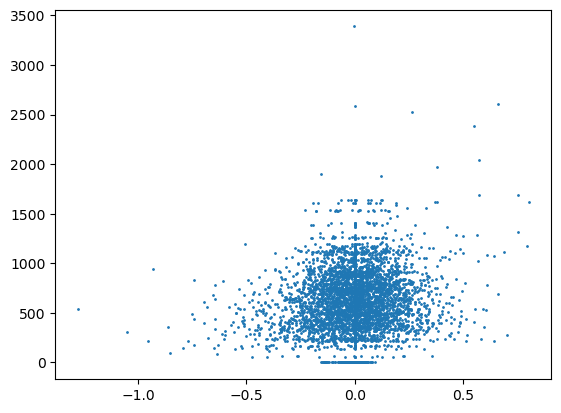

In [ ]:
plt.scatter(param_ravel.numpy(), jacob_ravel.numpy(), s=1)

In [ ]:
mask_ravel = []
for key, value in output_dict["mask_list"][-1].items():
    print(key, value.numel())
    mask_ravel.append(value.to('cpu').ravel())
    if key == "net.0.weight":
        mask_ravel.append(torch.ones(4))
    elif key == "net.3.weight":
        mask_ravel.append(torch.ones(16))
    elif key == "net.7.weight":
        mask_ravel.append(torch.ones(10))
mask_ravel = torch.cat(mask_ravel)

net.0.weight 36
net.3.weight 1024
net.7.weight 4000


In [ ]:
mask_ravel.shape

torch.Size([5090])

In [ ]:
param_ravel.shape

torch.Size([5090])

In [ ]:
!pip install seaborn

In [ ]:
import seaborn as sns

In [ ]:
import pandas as pd
data = {'Parameters': np.abs(param_ravel.numpy()), 'Jacobian': jacob_ravel.numpy(), 'Mask': mask_ravel.numpy()}
df = pd.DataFrame(data)

<Axes: xlabel='Parameters', ylabel='Jacobian'>

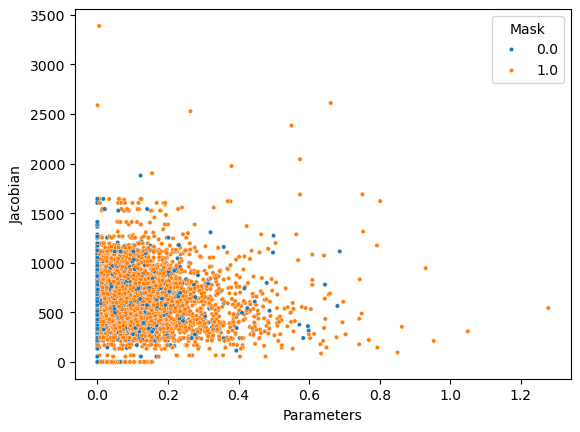

In [ ]:
sns.scatterplot(data=data, x='Parameters', y='Jacobian', hue='Mask', s=10)

<Axes: xlabel='Parameters', ylabel='Jacobian'>

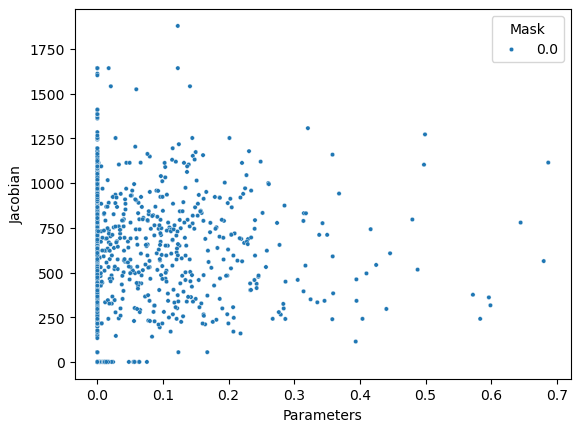

In [ ]:
#data_1 = data[data['Mask']==1]
sns.scatterplot(data=df[df['Mask']==0], x='Parameters', y='Jacobian', hue='Mask', s=10)

<Axes: xlabel='Parameters', ylabel='Jacobian'>

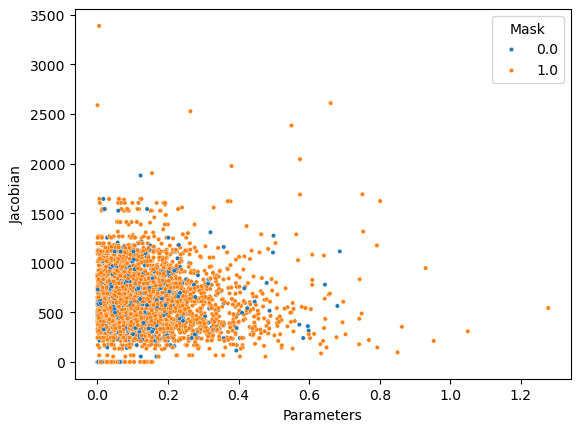

In [ ]:
#data_1 = data[data['Mask']==1]
sns.scatterplot(data=df[df['Parameters']!=0], x='Parameters', y='Jacobian', hue='Mask', s=10)